In [1]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# import TF and keras
import tensorflow as tf
from tensorflow import keras

import pandas as pd
from sklearn.model_selection import train_test_split

import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder


# Read in the dataset

My goal in this project is to determine a books genre based on its description, the following dataset is from a popular book rating website called goodreads, containing 10k entries

In [3]:
df = pd.read_csv("goodreads_data.csv")





df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


Some of the entries had no genres, and some had empty descriptions, also some contained non-english characters, so have to get rid of those

In [4]:
import re


# Convert the 'Description' column to strings
df['Description'] = df['Description'].astype(str)
df['Description'].fillna('', inplace=True)
df = df[df['Genres'] != '[]']

# Define a function to check if a string contains English letters
def contains_english(text):
    return bool(re.search('[a-zA-Z]', text[:10]))

# Apply the function to create a new column 'is_english'
df['is_english'] = df['Description'].apply(contains_english)

# Keep only rows where the 'is_english' column is True
df = df[df['is_english']]

# Drop the 'is_english' column
df = df.drop(columns=['is_english'])




df = df[df['Genres'] != 'nan']
df = df[(df['Description'].str.len() >= 20) & (df['Description'].str.len() <= 10000)] # Keep only descriptions that are more than 20 characters and less than 10000 to get rid of outliers
# Reset the index
df = df.reset_index(drop=True)

Now the description column is preproccessed, we can now move on to the target classes, Genres

As we can see, there are actually more genres than I thought were possible, this is an issue because now we have 613 classes to classify, and some of them probably only show up once in the whole dataset, so we have a highly unbalanced dataset

In [8]:
# Convert the 'Genres' column to a list of lists
df['Genres'] = df['Genres'].apply(eval)

# Extract the unique genres
genre_counts = {}

# Iterate through each list of genres in the 'Genres' column
for genres_list in df['Genres']:
    for genre in genres_list:
        # Increment the count for each genre
        genre_counts[genre] = genre_counts.get(genre, 0) + 1


genre_counts

613

To battle this, get the counts of how many times each genre appears

Now we select the genres that appear at least 1,500,1000,2000 times so our classes are a little more balanced, and we can test the model with these to check how much they affect the accuracy

In [9]:
# Filter out genres that appear less than 50 times
selected_genres500 = [genre for genre, count in genre_counts.items() if count >= 500]
selected_genres0 = [genre for genre, count in genre_counts.items() if count >= 1]
selected_genres1000 = [genre for genre, count in genre_counts.items() if count >= 1000]
selected_genres2000 = [genre for genre, count in genre_counts.items() if count >= 2000]

df_selected0 = df.copy()
df_selected500 = df.copy()
df_selected1000 = df.copy()
df_selected2000 = df.copy()


## Remove genres not in selected_genres from each list in 'Genres' column
df_selected0['Genres'] = df_selected2000['Genres'].apply(lambda genres: [genre for genre in genres if genre in selected_genres0])

# Filter the dataframe for genres with counts >= 0 (all genres)
df_selected500['Genres'] = df_selected2000['Genres'].apply(lambda genres: [genre for genre in genres if genre in selected_genres500])

# Filter the dataframe for genres with counts >= 1000
df_selected1000['Genres'] = df_selected2000['Genres'].apply(lambda genres: [genre for genre in genres if genre in selected_genres1000])

# Filter the dataframe for genres with counts >= 2000
df_selected2000['Genres'] = df_selected2000['Genres'].apply(lambda genres: [genre for genre in genres if genre in selected_genres2000])


# Reset the index
# Remove rows where the resulting list of genres is empty
#df_filtered = df[df['Genres'].apply(lambda genres: len(genres) > 0)]

#df_filtered = df_filtered.reset_index(drop=True)


In [10]:
df_selected2000.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"[Classics, Fiction]",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"[Fantasy, Fiction, Classics]",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","[Classics, Fiction]",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"[Classics, Nonfiction]",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"[Classics, Fiction, Fantasy]",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


In [11]:
# check the unique genres in the filtered dataset
#unique_genres = set(genre for genres_list in df_filtered['Genres'] for genre in genres_list)
#len(unique_genres)

df = df[df['Genres'].apply(lambda genres: bool(genres))]
df_selected0 = df_selected0[df_selected0['Genres'].apply(lambda genres: bool(genres))]
df_selected500 = df_selected500[df_selected500['Genres'].apply(lambda genres: bool(genres))]
df_selected1000 = df_selected1000[df_selected1000['Genres'].apply(lambda genres: bool(genres))]
df_selected2000 = df_selected2000[df_selected2000['Genres'].apply(lambda genres: bool(genres))]


We now encode the genres so we can input them into the model, encoding converts every genre with a unique value

In [13]:
# Use LabelEncoder to map unique genres to consecutive integers
label_encoder0 = LabelEncoder()
label_encoder0.fit(list(selected_genres0))
label_encoder500 = LabelEncoder()
label_encoder500.fit(list(selected_genres0))
label_encoder1000 = LabelEncoder()
label_encoder1000.fit(list(selected_genres0))
label_encoder2000 = LabelEncoder()
label_encoder2000.fit(list(selected_genres0))
print("Number of unique genres:", len(selected_genres0))
print("Unique genres:", selected_genres2000)
# Convert genre lists in 'Genres' column to integer-encoded lists
df_selected0['GenresEncoded'] = df_selected0['Genres'].apply(lambda genres_list: label_encoder0.transform(genres_list).tolist())
df_selected500['GenresEncoded'] = df_selected500['Genres'].apply(lambda genres_list: label_encoder500.transform(genres_list).tolist())
df_selected1000['GenresEncoded'] = df_selected1000['Genres'].apply(lambda genres_list: label_encoder1000.transform(genres_list).tolist())
df_selected2000['GenresEncoded'] = df_selected2000['Genres'].apply(lambda genres_list: label_encoder2000.transform(genres_list).tolist())

Number of unique genres: 613
Unique genres: ['Classics', 'Fiction', 'Fantasy', 'Nonfiction']


A bit of preproccessing on the description column, need to turn every description to the same length in order to use in the RNN, use fillna('') to turn NaN values to empty strings, since I was getting a float object attribute error.

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer


descriptions = df_selected0['Description'].astype(str)
descriptions500 = df_selected500['Description'].astype(str)
descriptions1000 = df_selected1000['Description'].astype(str)
descriptions2000 = df_selected2000['Description'].astype(str)

def tokenize_and_pad(df_descriptions, maxlen):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(df_descriptions)

    sequences = tokenizer.texts_to_sequences(df_descriptions)
    mean_length = 500

    padded_sequences = pad_sequences(sequences, maxlen=mean_length, padding='post', truncating='post')

    return padded_sequences, tokenizer, mean_length

# Tokenize and pad sequences for each DataFrame
padded_sequences, tokenizer, mean_length = tokenize_and_pad(descriptions, maxlen=None)
padded_sequences_10 = pad_sequences(padded_sequences, maxlen=10, padding='post', truncating='post')

padded_sequences_500, tokenizer_500, mean_length_500 = tokenize_and_pad(descriptions500, maxlen=None)
padded_sequences_10_500 = pad_sequences(padded_sequences_500, maxlen=10, padding='post', truncating='post')

padded_sequences_1000, tokenizer_1000, mean_length_1000 = tokenize_and_pad(descriptions1000, maxlen=None)
padded_sequences_10_1000 = pad_sequences(padded_sequences_1000, maxlen=10, padding='post', truncating='post')

padded_sequences_2000, tokenizer_2000, mean_length_2000 = tokenize_and_pad(descriptions2000, maxlen=None)
padded_sequences_10_2000 = pad_sequences(padded_sequences_2000, maxlen=10, padding='post', truncating='post')


df = df.reset_index(drop=True)

In [16]:
padded_sequences.shape

(8913, 500)

In [17]:
len(tokenizer_500.word_index)

72401

First we must use the MultiLaberBinarizer to transform our Encoded Genres so they are split into binary matrices, having a 0 or a 1 in the corresponding spot where the encoded genre is, this will also ensure that the dimensions are right for the target classes, all containing the 96 genres

In [19]:
X = padded_sequences
X500 = padded_sequences_500
X1000 = padded_sequences_1000
X2000 = padded_sequences_2000
X10 = padded_sequences_10

X500_10 = padded_sequences_10_500
X1000_10 = padded_sequences_10_1000
X2000_10 = padded_sequences_10_2000

Y = df_selected0['GenresEncoded']
Y500 = df_selected500['GenresEncoded']
Y1000 = df_selected1000['GenresEncoded']
Y2000 = df_selected2000['GenresEncoded']

mlb = MultiLabelBinarizer()
mlb500 = MultiLabelBinarizer()
mlb1000 = MultiLabelBinarizer()
mlb2000 = MultiLabelBinarizer()
# Fit and transform the labels
Y_encoded = mlb.fit_transform(Y)
Y500_encoded = mlb500.fit_transform(Y500)
Y1000_encoded = mlb1000.fit_transform(Y1000)
Y2000_encoded = mlb2000.fit_transform(Y2000)






# Split the data into training (80%) and temporary set (20%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y_encoded, test_size=0.2)
# Split the temporary set into validation (50%) and testing (50%)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5)


# Split the data for Y500
X_train_500, X_temp_500, Y_train_500, Y_temp_500 = train_test_split(X500_10, Y500_encoded, test_size=0.2)
X_valid_500, X_test_500, Y_valid_500, Y_test_500 = train_test_split(X_temp_500, Y_temp_500, test_size=0.5)

# Split the data for Y1000
X_train_1000, X_temp_1000, Y_train_1000, Y_temp_1000 = train_test_split(X1000_10, Y1000_encoded, test_size=0.2)
X_valid_1000, X_test_1000, Y_valid_1000, Y_test_1000 = train_test_split(X_temp_1000, Y_temp_1000, test_size=0.5)

# Split the data for Y2000
X_train_2000, X_temp_2000, Y_train_2000, Y_temp_2000 = train_test_split(X2000_10, Y2000_encoded, test_size=0.2)
X_valid_2000, X_test_2000, Y_valid_2000, Y_test_2000 = train_test_split(X_temp_2000, Y_temp_2000, test_size=0.5)


This is the model I ended up with, it is not perfect as I had trouble even finding examples or concrete methods of how to improve my model, since every problem is somewhat unique, I found that adding 1 bidirectional layers has increased the accuracy but drastically increases the time to run. Interestingly, if I add another bidirectional layer the model gets worse.

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D, Conv1D, GlobalMaxPooling1D

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=512, input_length=10))
model.add(LSTM(units=200, return_sequences=True))
model.add(LSTM(units=300, return_sequences=True))
model.add(Dense(units=512, activation='relu'))  # Additional Dense layer
model.add(LSTM(units=400, return_sequences=True))
model.add(LSTM(units=500, return_sequences=True))
model.add(Bidirectional(LSTM(units=200, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(LSTM(units=600))
model.add(Dense(units=256, activation='relu'))  # Additional Dense layer
model.add(Dropout(0.2))
model.add(Dense(units=len(mlb500.classes_), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])




# Define the path where to save the best model weights
checkpoint_path = 'best_model_weights.h5'

# Create ModelCheckpoint callback
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  
    save_best_only=True,
    save_weights_only=True,
    mode='max',  
    verbose=1
)


history1 = model.fit(
    X_train_500, Y_train_500,
    epochs=30,
    validation_data=(X_valid_500, Y_valid_500),
    callbacks=[model_ckpt]
)





model.load_weights(checkpoint_path)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_500, Y_test_500)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')



Epoch 1/30
218/218 [==============================] - ETA: 0s - loss: 0.3850 - accuracy: 0.0736
Epoch 1: val_accuracy improved from -inf to 0.07003, saving model to best_model_weights.h5
218/218 [==============================] - 383s 2s/step - loss: 0.3850 - accuracy: 0.0736 - val_loss: 0.3670 - val_accuracy: 0.0700
Epoch 2/30
218/218 [==============================] - ETA: 0s - loss: 0.3691 - accuracy: 0.0743
Epoch 2: val_accuracy did not improve from 0.07003
218/218 [==============================] - 355s 2s/step - loss: 0.3691 - accuracy: 0.0743 - val_loss: 0.3644 - val_accuracy: 0.0700
Epoch 3/30
218/218 [==============================] - ETA: 0s - loss: 0.3545 - accuracy: 0.0737
Epoch 3: val_accuracy did not improve from 0.07003
218/218 [==============================] - 353s 2s/step - loss: 0.3545 - accuracy: 0.0737 - val_loss: 0.3606 - val_accuracy: 0.0700
Epoch 4/30
218/218 [==============================] - ETA: 0s - loss: 0.3339 - accuracy: 0.0756
Epoch 4: val_accuracy did n

I made different models for each of the different dataframes with the different amount of genre counts, it is not efficient but I wanted to show each models performance

In [23]:
model1 = Sequential()
model1.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=512, input_length=10))
model1.add(LSTM(units=200, return_sequences=True))
model1.add(LSTM(units=300, return_sequences=True))
model1.add(Dense(units=512, activation='relu'))  # Additional Dense layer
model1.add(LSTM(units=400, return_sequences=True))
model1.add(LSTM(units=500, return_sequences=True))
model1.add(Bidirectional(LSTM(units=200, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model1.add(LSTM(units=600))
model1.add(Dense(units=256, activation='relu'))  # Additional Dense layer
model1.add(Dropout(0.2))
model1.add(Dense(units=len(mlb1000.classes_), activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

checkpoint_path = 'best_model_weights.h5'

# Create ModelCheckpoint callback
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # or 'val_loss' depending on your preference
    save_best_only=True,
    save_weights_only=True,
    mode='max',  # or 'min' if monitoring loss
    verbose=1
)

history2 = model1.fit(
    X_train_1000, Y_train_1000,
    epochs=30,
    validation_data=(X_valid_1000, Y_valid_1000),
    callbacks=[model_ckpt]
)

model1.load_weights(checkpoint_path)

# Evaluate the model on the test set
test_loss, test_accuracy = model1.evaluate(X_test_1000, Y_test_1000)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/30
216/216 [==============================] - ETA: 0s - loss: 0.4846 - accuracy: 0.1364
Epoch 1: val_accuracy improved from -inf to 0.13689, saving model to best_model_weights.h5
216/216 [==============================] - 375s 2s/step - loss: 0.4846 - accuracy: 0.1364 - val_loss: 0.4668 - val_accuracy: 0.1369
Epoch 2/30
216/216 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.1909
Epoch 2: val_accuracy improved from 0.13689 to 0.22390, saving model to best_model_weights.h5
216/216 [==============================] - 376s 2s/step - loss: 0.4583 - accuracy: 0.1909 - val_loss: 0.4496 - val_accuracy: 0.2239
Epoch 3/30
216/216 [==============================] - ETA: 0s - loss: 0.4162 - accuracy: 0.2632
Epoch 3: val_accuracy improved from 0.22390 to 0.22970, saving model to best_model_weights.h5
216/216 [==============================] - 389s 2s/step - loss: 0.4162 - accuracy: 0.2632 - val_loss: 0.4613 - val_accuracy: 0.2297
Epoch 4/30
216/216 [=================

In [24]:
model2 = Sequential()
model2.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=512, input_length=10))
model2.add(LSTM(units=200, return_sequences=True))
model2.add(LSTM(units=300, return_sequences=True))
model2.add(Dense(units=512, activation='relu'))  # Additional Dense layer
model2.add(LSTM(units=400, return_sequences=True))
model2.add(LSTM(units=500, return_sequences=True))
model2.add(Bidirectional(LSTM(units=200, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model2.add(LSTM(units=600))
model2.add(Dense(units=256, activation='relu'))  # Additional Dense layer
model2.add(Dropout(0.2))
model2.add(Dense(units=len(mlb2000.classes_), activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

checkpoint_path = 'best_model_weights.h5'

# Create ModelCheckpoint callback
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # or 'val_loss' depending on your preference
    save_best_only=True,
    save_weights_only=True,
    mode='max',  # or 'min' if monitoring loss
    verbose=1
)

history3 = model2.fit(
    X_train_2000, Y_train_2000,
    epochs=30,
    validation_data=(X_valid_2000, Y_valid_2000),
    callbacks=[model_ckpt]
)

model2.load_weights(checkpoint_path)

# Evaluate the model on the test set
test_loss, test_accuracy = model2.evaluate(X_test_2000, Y_test_2000)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/30
208/208 [==============================] - ETA: 0s - loss: 0.5922 - accuracy: 0.3014
Epoch 1: val_accuracy improved from -inf to 0.28072, saving model to best_model_weights.h5
208/208 [==============================] - 393s 2s/step - loss: 0.5922 - accuracy: 0.3014 - val_loss: 0.5839 - val_accuracy: 0.2807
Epoch 2/30
208/208 [==============================] - ETA: 0s - loss: 0.4976 - accuracy: 0.4240
Epoch 2: val_accuracy improved from 0.28072 to 0.37590, saving model to best_model_weights.h5
208/208 [==============================] - 360s 2s/step - loss: 0.4976 - accuracy: 0.4240 - val_loss: 0.6019 - val_accuracy: 0.3759
Epoch 3/30
208/208 [==============================] - ETA: 0s - loss: 0.3839 - accuracy: 0.4937
Epoch 3: val_accuracy improved from 0.37590 to 0.39880, saving model to best_model_weights.h5
208/208 [==============================] - 364s 2s/step - loss: 0.3839 - accuracy: 0.4937 - val_loss: 0.5690 - val_accuracy: 0.3988
Epoch 4/30
208/208 [=================

Obviously the model using the Genres with over 2000 entries is the most accurate, however it is still only 40% accurate on the test set, and the test loss is incredibely high, this is probably due to all descriptions sharing words, so it is hard for the model to differentiate. To plot the history of each model using genres with over 500, 1000 and 2000,

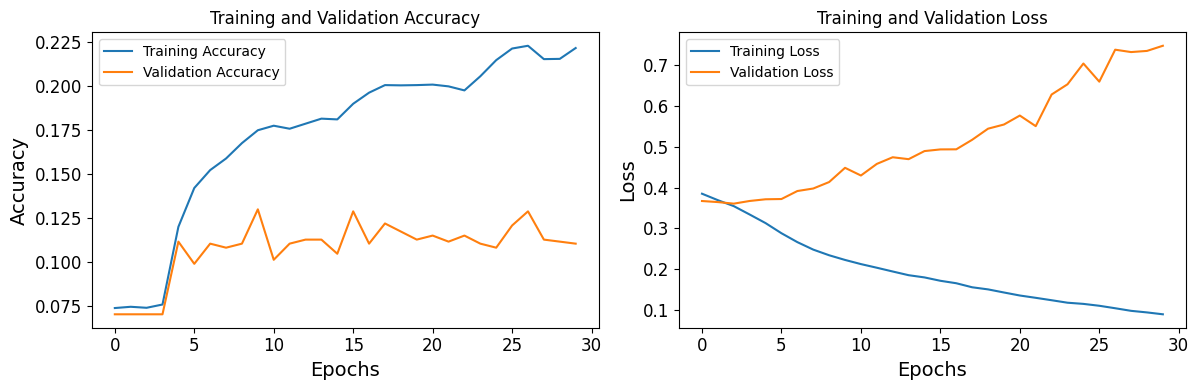

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (genres with at least 500 appearances)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

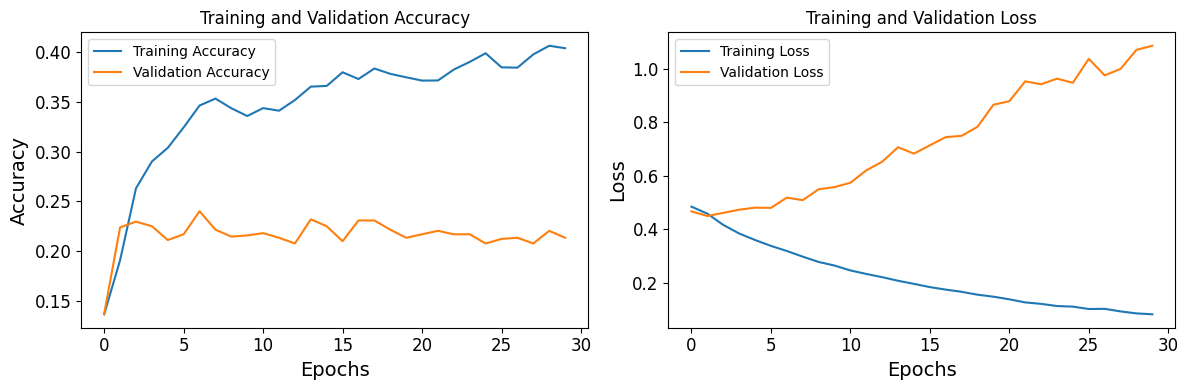

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy (genres with at least 1000 appearances)')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (genres with at least 1000 appearances)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

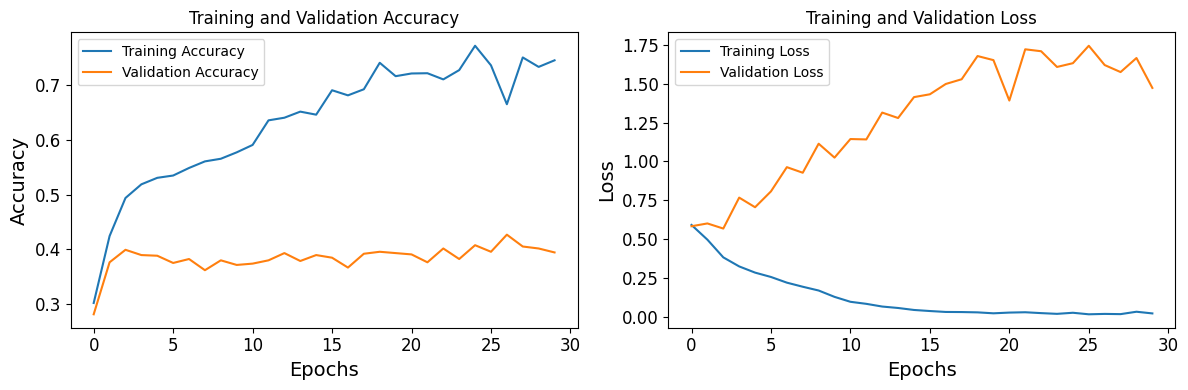

In [26]:



plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (genres with at least 2000 appearances)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

As we can see in each case the validation accuracy plateued off fairly quickly, while the training accuracy kept going up, meaning overfitting to the training data, and it is also obvious by the validation loss getting higher and higher.

This model using more complicated layers did not increase accuracy but ran for over an hour for 1 epoch, perhaps suggesting that the issue is with the amount of data or that the predictor variable is not correlated to the response.

In [ ]:
model1 = Sequential()
model1.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=10))
#model1.add(SpatialDropout1D(0.2))

model1.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2)))
model1.add(LSTM(units=200, return_sequences=True))
model1.add(LSTM(units=300, return_sequences=True))
model1.add(Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.2)))
model1.add(LSTM(units=200, return_sequences=True))
model1.add(LSTM(units=300, return_sequences=True))

model1.add(Dense(units=256, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Bidirectional(LSTM(units=200, return_sequences=True, recurrent_dropout=0.2)))
model1.add(LSTM(units=200, return_sequences=True))
model1.add(LSTM(units=300, return_sequences=True))
model1.add(Bidirectional(LSTM(units=250, return_sequences=True,  recurrent_dropout=0.2)))
model1.add(LSTM(units=200, return_sequences=True))
model1.add(LSTM(units=300, return_sequences=True))
model1.add(Bidirectional(LSTM(units=300, dropout=0.2, recurrent_dropout=0.2)))

model1.add(Dense(units=128, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(units=len(mlb500.classes_), activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model

checkpoint_path = 'best_model_weights.h5'

# Create ModelCheckpoint callback
model_ckpt = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # or 'val_loss' depending on your preference
    save_best_only=True,
    save_weights_only=True,
    mode='max',  # or 'min' if monitoring loss
    verbose=1
)


history1 = model1.fit(
  X_train_500, Y_train_500,
   epochs=20,
   validation_data=(X_valid_500, Y_valid_500),
    callbacks=[model_ckpt]

)


If i had more time I would test out more diverse layers in the neural network, I would also try to give weights to certain words, as many words are shared by all descriptions, such as "The" "Of" "When" and words of that nature that are used by almost all texts. Perhaps a bigger dataset would also help in improving the model. Finally because training takes so long I had to resort to using only first 10 words of every description, if I had more time I wouldve liked to run with 500 or however many words I could.